<h1>Project Description</h1><br>
The purpose of this project is to:
<ul>
<li>See the popularity of Trump's tweets across countries</li>
<li>Perform a sentiment analysis of recent tweets by Trump across countries</li>
<li>See if similar reactions occur if his tweets are talking about the same topic</li>
</ul>

<h1>Data Collection</h1>

<h2>Trump tweets data</h2>

We utilised the several datasets available at https://github.com/bpb27/trump_tweet_data_archive which happens to automatically updata Trump's tweets every hour. All of the datasets are saved in json format and the data contained in them is the result of calls to the Twitter API. There are two varients, <b>master</b> which contains all of the original information from the API call and <b>condensed</b> which contains a lot less but essential information. After looking through some of the master and condensed datasets, we decided that the condensed datasets were sufficient as they contained the specfic fields we required (such as ...?) and the entries in master were unnecessarily large for our purpose (too much information that we would not use). <br>

We're using all of the condensed datasets from 2009 to 2017 because the tweet data isn't that time consuming to process and having as much data as possible will be beneficial when clustering the messages in the tweets. Since the 2017 datatset is continiously being updated, we are only using it up to a certain date (--/--/2017). All of the data in total is around 10 MB so it is really simple to handle and there is no need to rely on additional computing resources<br>

Below, we import all the necessary libraries we need for extracting and combining the data. We iterate over each json file and turn them into a pandas DataFrame and store them in the list <b>data</b>. We do this so that later on we can simply combine them into one single dataframe.

In [4]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

In [5]:
#Create empty list to store all of our data
data=[]

#Add data from 2009 to 2017, 2017 data obtained 28/11/2017
data.append(pd.DataFrame(json.load(open("data/condensed_2009.json"))))
for i in range(10,18):
    fileName="data/condensed_20"+str(i)+".json"
    data.append(pd.DataFrame(json.load(open(fileName))))

Next, we combine all of our seperate datasets into one pandas dataframe. We also set the id of the dataframe to <b>id_str</b> since we already know that each of the ids are unique. we also have to convert the <b>created_at</b> attribute into a Date object so that the dataframe is able to properly sort tweets by date (if it was still a string then it would sort incorrectly as it would put tweets starting on a Friday first.

In [6]:
#Combine all of the individual datasets together
df = pd.concat(data)

#Set the index
df = df.set_index("id_str")

#Convert to Date
df["created_at"]=pd.to_datetime(df["created_at"])

In [8]:
df.sort_values("created_at",inplace=True)
df.head()

,created_at,favorite_count,in_reply_to_user_id_str,is_retweet,retweet_count,source,text
id_str,,,,,,,
1698308935,2009-05-04 18:54:25,202,None,False,253,Twitter Web Client,Be sure to tune in and watch Donald Trump on L...
1701461182,2009-05-05 01:00:10,3,None,False,2,Twitter Web Client,Donald Trump will be appearing on The View tom...
1737479987,2009-05-08 13:38:08,2,None,False,3,Twitter Web Client,Donald Trump reads Top Ten Financial Tips on L...
1741160716,2009-05-08 20:40:15,27,None,False,8,Twitter Web Client,New Blog Post: Celebrity Apprentice Finale and...
1773561338,2009-05-12 14:07:28,1950,None,False,1421,Twitter Web Client,"""My persona will never be that of a wallflower..."


<h2>Reply tweets data</h2>

In order to do a sentiment analysis, we need to create a dataframe containing replies to Trump's tweets. To do this, we use the library Twarc which simplifies the API call process. Note that due to a limitation in the Twitter API, getting replies to a tweet is not a feature by default so you have to use a workaround. One thing that's commonly done is to use Twitter's search function, it would involve searching for all messages directed at Trump and then seeing which ones have a reply_id (the id of the tweet they are replying to) that is equal to a given Trump tweet id. The problem with this is that it is only able to look for replies to tweets that are max a wekk old. The second issue is that the amount of times that you can use the search function in the Twitter API is limited to a 100 queries an hour which is not ideal since it would take too long to get enough tweets to train our classifiers.

Instead, we decided to do the following. We iterate over all of Trump's tweets, get the id of these tweets and then do a http request to the twitter page containing that tweet. Then we parse the page using BeautifulSoup and search for the attribute "data-tweet-id" in the HTML text. This attribute corresponds to an id of any tweet on that page which means that we can easily obtain the id of replies. Then, instead of using the search function in the Twitter API, we use a different method that can lookup tweet information given an id. This method is not limited to tweets that are more than 7 days old and has a higher rate limit. 

We are using the package Twarc and to use it we need authenticate it with keys and access tokens that can be obtained from the Twitter Dev website.

In [9]:
from twarc import Twarc
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [12]:
consumer_key="zjwAsouRHgMzrMJxpWNxJtJYJ"
consumer_secret="uu2j3Do5fm266BPY2OiCajnIbUvWEiccgmfiNRZ9tGIfso1leN"
access_token="2758505181-7z1gXy1DgJDeGh1UqWwqiPeupQKmbapYPAeZ9QE"
access_token_secret="GjcjOwMzMwpjfFDW4an2qd1jwykYiYw0L5lb702PNHtYL"
t = Twarc(consumer_key, consumer_secret, access_token, access_token_secret)

In [13]:
#A list of lists for creating the dataframe
L=[]
for i in range(len(indexList)):
    L.append([])

#Column names for our dataframe containing replies
indexList=["reply_id","trump_id","created_at","coordinates","favorite_count","retweet_count","geo",
                              "place","full_text","location","time_zone","utc_offset"]

#Create empty dataframe
replyDf=pd.DataFrame(columns=indexList)

#Sort trump dataframe to get recent first
df.sort_values("created_at",inplace=True,ascending=False)

#Adds the information from the reply tweet into our list of lists L
def CreateReplyEntry(trumpId,replyId,replyTweet):
    L[0].append(replyId)
    L[1].append(trumpId)
    for i in range(len(indexList)):
        if(i>1):
            if(i>8):
                L[i].append(replyTweet["user"][indexList[i]])
            else:
                L[i].append(replyTweet[indexList[i]])

#Iterate over every tweet
for i in range(len(df)):
    
    #Set a limit so it doesn't take forever
    if(i>10):
        break
        
    #Get trump tweet and id
    tweet=df.iloc[i]
    tweetId=df.index[i]

    url="https://twitter.com/realDonaldTrump/status/"+tweetId
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')

    #Finds all div tags and if it has the corresponding id, add that id to a list
    soup.find_all("div")
    divs = soup.find_all("div")
    ids=[]
    for d in divs:
        if d.has_attr('data-tweet-id'):
            ids.append(d["data-tweet-id"])  

    for i in ids:
        if(i!=tweetId): #dont want trump's tweet, just replies
            reply=t.tweet(i)
            CreateReplyEntry(tweetId,i,reply)   


for i in range(len(indexList)):
    replyDf[indexList[i]]=L[i]
    
replyDf

,reply_id,trump_id,created_at,coordinates,favorite_count,retweet_count,geo,place,full_text,location,time_zone,utc_offset
0,935340287521460224,935340092583006208,Tue Nov 28 02:51:16 +0000 2017,None,956,116,None,None,@realDonaldTrump Best \n\nPresident \n\nEver \...,"Las Vegas, NV",Pacific Time (US & Canada),-28800.0
1,935340357084110848,935340092583006208,Tue Nov 28 02:51:33 +0000 2017,None,729,83,None,None,@realDonaldTrump Best \n\nFirst Lady \n\nEver ...,"Las Vegas, NV",Pacific Time (US & Canada),-28800.0
2,935340437627269120,935340092583006208,Tue Nov 28 02:51:52 +0000 2017,None,542,49,None,None,@realDonaldTrump Best \n\nVice President \n\nE...,"Las Vegas, NV",Pacific Time (US & Canada),-28800.0
3,935340506506174464,935340092583006208,Tue Nov 28 02:52:09 +0000 2017,None,428,35,None,None,@realDonaldTrump Best \n\nSecretary of State \...,"Las Vegas, NV",Pacific Time (US & Canada),-28800.0
4,935340576022528001,935340092583006208,Tue Nov 28 02:52:25 +0000 2017,None,411,34,None,None,@realDonaldTrump Best \n\nSecretary of Defense...,"Las Vegas, NV",Pacific Time (US & Canada),-28800.0
5,935340653923287040,935340092583006208,Tue Nov 28 02:52:44 +0000 2017,None,390,32,None,None,@realDonaldTrump Best \n\nChief of Staff \n\nE...,"Las Vegas, NV",Pacific Time (US & Canada),-28800.0
6,935340890092060673,935340092583006208,Tue Nov 28 02:53:40 +0000 2017,None,339,50,None,None,@realDonaldTrump .@SenWarren \n\nLied \n\nAbou...,"Las Vegas, NV",Pacific Time (US & Canada),-28800.0
7,935343119100506114,935340092583006208,Tue Nov 28 03:02:32 +0000 2017,None,0,0,None,None,@JohnPaul_USA @realDonaldTrump @SenWarren 👍......,,None,NaN
8,935342484829372417,935340092583006208,Tue Nov 28 03:00:00 +0000 2017,None,178,101,None,None,@realDonaldTrump https://t.co/2a5leXVlmo,United States,Pacific Time (US & Canada),-28800.0
9,935342619181355008,935340092583006208,Tue Nov 28 03:00:32 +0000 2017,None,127,15,None,None,@realDonaldTrump https://t.co/hVjXxrGm54,United States,Pacific Time (US & Canada),-28800.0


<h1>Analyzing the data</h1><br>

<h2>Attributes in the condensed Trump data</h2>

What does the data look like ? In each json file, there is an array where each element represents
a seperate tweet. In each array element, the following information can be found:<br>

<ul>
<li><b>created_at:</b> (string) the date the tweet was posted<br></li>
<li><b>favourite_count:</b> (integer) represents the number of individual users that liked this post<br></li>
<li><b>id_str:</b> (string) a unique string id for this tweet provided by the API<br></li>
<li><b>in_reply_to_user_id_str:</b> (string) the string id of a tweet that this tweet is a reply to<br></li>
<li><b>is_retweet:</b> (boolean) True if this tweet is a retweet of another tweet <br></li>
<li><b>retweet_count:</b> (integer) an integer representing the amount of times this tweet was retweeted<br></li>
<li><b>source:</b> (string/categorical) the type of device this tweet was posted from (for example a desktop or phone)<br></li>
<li><b>text:</b> (string) the actual text from this tweet<br></li>
</ul>


To see all of the possible values of <b>source</b>, we simply use the following line:

In [128]:
df["source"].unique()

array(['Twitter Web Client', 'TweetDeck', 'TwitLonger Beta', 'Facebook',
       'Twitter for iPhone', 'Mobile Web (M5)', 'Twitter for Android',
       'Instagram', 'Twitlonger', 'Vine - Make a Scene',
       'Twitter for Websites', 'Twitter for BlackBerry',
       'Neatly For BlackBerry 10', 'Periscope', 'Twitter QandA',
       'Twitter Mirror for iPad', 'Twitter Ads', 'Twitter for iPad',
       'Media Studio'], dtype=object)

<b>favourite_count</b> and <b>retweet_count</b> are both positive integers

Below is an example of what 1 entry may look like

In [78]:
df.iloc[0]

created_at                                               2009-05-04 18:54:25
favorite_count                                                           202
in_reply_to_user_id_str                                                 None
is_retweet                                                             False
retweet_count                                                            253
source                                                    Twitter Web Client
text                       Be sure to tune in and watch Donald Trump on L...
Name: 1698308935, dtype: object

One important thing to be noted about twitter for those who are unfamiliar, a retweet is essentially where you take someone else's tweet and post that to your twitter feed where as a reply is a tweet that is directly aimed at an existing tweet. 

What we can see from the dataset above is that not all of the information we need is there. For example to do a proper sentiment analysis of people reacting to Trump, we need to look at the replies of these people. For that we need an external library such as ... ??? Also, we need to see what country those replies originated from. This can be done using the twitter API since the API calls contain more extensive information such as geolocation of the tweet's origin. 

If we take a look at the tweets themselves, we see that there is certain symbols and text that we can remove as they don't contribute to our clustering of topics. For example, a lot of tweets contain external http links. Also, twitter happens to encode the & symbol as the string &amp so these need to be converted. 


<h2>Computing statistical information</h2>

Using the describe function below, we can see that there are 30192 tweets in our total dataset. Only two of the features can have these values computed because the rest are strings or booleans. 

In [119]:
df.describe()

,favorite_count,retweet_count
count,30192.000000,30192.000000
mean,3385.386228,1363.948198
std,12319.745232,4813.511737
min,0.000000,0.000000
25%,19.000000,15.000000
50%,58.000000,74.000000
75%,773.750000,684.250000
max,633253.000000,344806.000000


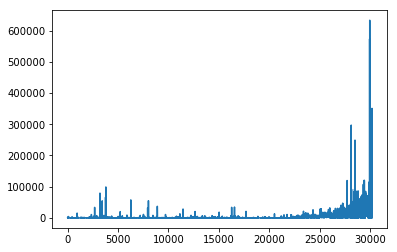

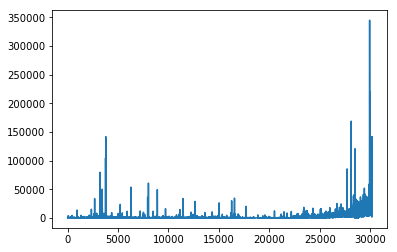

In [123]:
plt.plot(list(df["favorite_count"]))
plt.show()
plt.plot(list(df["retweet_count"]))
plt.show()

<h2>Checking for missing values</h2>

We will now check to see if there are potentially any values missing at all. Note that we don't consider a value of None in <b>in_reply_to_user_id_str</b> to be a missing value as it's acceptable for a tweet to not reply to another. We make a copy of our original dataframe, drop the in_reply_to_user_id_str (because pandas think's that the value None is a null value in this case) and then do a query to return all entries with some form of missing value. As we can see, we get no entries in this case so all of the values are present.

In [79]:
dfNull=df.copy()
dfNull=dfNull.drop("in_reply_to_user_id_str",axis=1)
dfNull[dfNull.isnull().any(axis=1)]

,created_at,favorite_count,is_retweet,retweet_count,source,text
id_str,,,,,,


<h2>Correlations between features</h2>

Next we want to analyze the correlations between the different fields. It doesn't make sense to look at correlations between string fields and the rest as the strings can take on a large range of values that aren't repeated often. However we can convert the categorical strings into integers as they occur frequently. We create a copy of the dataframe and then create a dictionary to have a mapping from a <b>source</b> value to an integer. Then we alter all of the rows in this datafram to have these integer values.

In [99]:
dfCorr=df.copy()

keys=dfCorr["source"].unique()
values=list(range(len(keys)))
dictionary = dict(zip(keys, values))

for i in range(len(dfCorr)):    
    s=dfCorr.iloc[i]["source"]
    dfCorr.iloc[i, dfCorr.columns.get_loc('source')] = int(dictionary.get(s))
    
dfCorr["source"] = dfCorr["source"].astype('int64')

In [109]:
dfCorr.dtypes

created_at                 datetime64[ns]
favorite_count                      int64
in_reply_to_user_id_str            object
is_retweet                           bool
retweet_count                       int64
source                              int64
text                               object
dtype: object

Below is a correlation matrix between all of the integer values as well as 

In [115]:
corrMatr=dfCorr.corr(method='pearson', min_periods=1)
corrMatr

,favorite_count,is_retweet,retweet_count,source
favorite_count,1.000000,-0.021752,0.916265,0.134390
is_retweet,-0.021752,1.000000,0.084379,-0.002959
retweet_count,0.916265,0.084379,1.000000,0.100975
source,0.134390,-0.002959,0.100975,1.000000


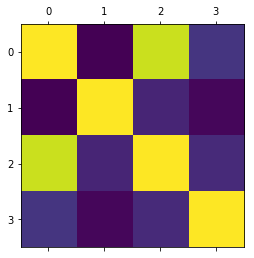

In [114]:
plt.matshow(corrMatr)
plt.show()

To interpret the matrix, yellow is for 100% correlation (when a variable correlates to itself), the more darker colours represent less correlation and the green one show that there is a relatively high correlation (>90%). What we see is that for Trump's tweets, the <b>favorite_count</b> and <b>retweet_count</b> are highly correlated. The correlations between the other variables are quite low (from -0.021752 to 0.134390)

<h1>Roadmap to Milestone 3</h1>

This section contains all the tasks that we intend to complete for the 3rd milestone.

<h3>Classification of Trump's tweets by topic</h3>
<h3>Classify users' reaction to a topic by sentiment and country.</h3>
<h3>Plot a world map for each topic</h3>


<h3>Plan for presentation</h3>